# Bidirectional LSTM

### Compare LSTM to Bidirectional LSTM

We will compare the performance of traditional LSTMs to a Bidirectional LSTM over time while the models are being trained. We will compare three different models; specifically:

    1) LSTM (as-is)
    2) LSTM with reversed input sequences (e.g. you can do this by setting the “go_backwards” argument to he LSTM layer to “True”)
    3) Bidirectional LSTM

This comparison will help to show that bidirectional LSTMs can in fact add something more than simply reversing the input sequence.

Source: https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/

In [1]:
from random import random
from numpy import array
from numpy import cumsum
from pandas import DataFrame
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Bidirectional

In [2]:
from matplotlib import pyplot
%matplotlib inline

## Data Generation

The input layer will have 10 timesteps with 1 feature a piece, input_shape=(10, 1).

The first hidden layer will have 20 memory units and the output layer will be a fully connected layer that outputs one value per timestep. A sigmoid activation function is used on the output to predict the binary value.

A new random input sequence will be generated each epoch for the network to be fit on. 

In [3]:
# create a sequence classification instance
def get_sequence(n_timesteps):
    # create a sequence of random numbers in [0,1]
    X = array([random() for _ in range(n_timesteps)])
    # calculate cut-off value to change class values
    limit = n_timesteps/4.0
    # determine the class outcome for each item in cumulative sequence
    y = array([0 if x < limit else 1 for x in cumsum(X)])
    # reshape input and output data to be suitable for LSTMs
    X = X.reshape(1, n_timesteps, 1)
    y = y.reshape(1, n_timesteps, 1)
    return X, y

In [4]:
seq = get_sequence(10)
seq

(array([[[0.59832805],
         [0.90706691],
         [0.81435536],
         [0.50750672],
         [0.99828127],
         [0.89732536],
         [0.22878587],
         [0.28009728],
         [0.41481756],
         [0.61369278]]]),
 array([[[0],
         [0],
         [0],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1]]]))

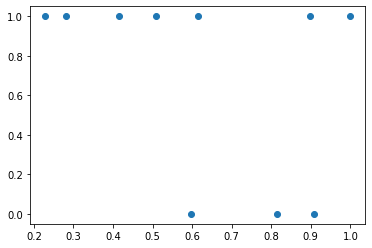

In [17]:
#plot one sample sequence which will be fed into the LSTM
pyplot.scatter(seq[0][0],seq[1][0])

## Build Models

A **TimeDistributed** wrapper layer is used around the output layer so that one value per timestep can be predicted given the full sequence provided as input. This requires that the LSTM hidden layer returns a sequence of values (one per timestep) rather than a single value for the whole input sequence.

Since this is a binary classification problem, the binary log loss (binary_crossentropy in Keras) is used. We will use the efficient Adam optimization algorithm and the accuracy metric is calculated and reported each epoch.

### LSTM

We will define a function to create and return an LSTM with either forward or backward input sequences, as follows:

In [6]:
def get_lstm_model(n_timesteps, backwards):
    model = Sequential()
    model.add(LSTM(20, input_shape=(n_timesteps, 1), return_sequences=True, go_backwards=backwards))
    model.add(TimeDistributed(Dense(1, activation='sigmoid')))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

### Bidirectional LSTM 
We can develop a similar function for bidirectional LSTMs where the merge mode can be specified as an argument. The default of concatenation can be specified by setting the merge mode to the value ‘concat’.

In [7]:
def get_bi_lstm_model(n_timesteps, mode):
    model = Sequential()
    model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(n_timesteps, 1), merge_mode=mode))
    model.add(TimeDistributed(Dense(1, activation='sigmoid')))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

## Training 

The LSTM will be trained for 250 epochs. A new random input sequence will be generated each epoch for the network to be fit on. This ensures that the model does not memorize a single sequence and instead can generalize a solution to solve all possible random input sequences for this problem.

In [8]:
def train_model(model, n_timesteps):
    loss = list()
    for _ in range(250):
        # generate new random sequence
        X,y = get_sequence(n_timesteps)
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, epochs=1, batch_size=1, verbose=0)
        loss.append(hist.history['loss'][0])
    return loss

We can see that the LSTM forward (blue) and LSTM backward (orange) show similar log loss over the 250 training epochs.

We can see that the Bidirectional LSTM log loss is different (green), going down sooner to a lower value and generally staying lower than the other two configurations.

In [9]:
n_timesteps = 10
results = DataFrame()
# lstm forwards
model = get_lstm_model(n_timesteps, False)
results['lstm_forw'] = train_model(model, n_timesteps)
# lstm backwards
model = get_lstm_model(n_timesteps, True)
results['lstm_back'] = train_model(model, n_timesteps)
# bidirectional concat
model = get_bi_lstm_model(n_timesteps, 'concat')
results['bilstm_con'] = train_model(model, n_timesteps)

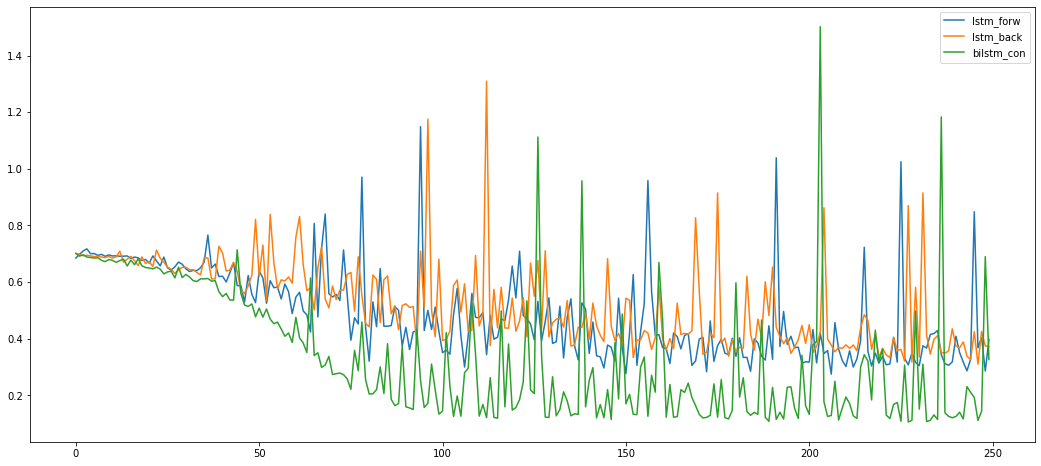

In [10]:
# line plot of results
results.plot(figsize=(18,8))

### Comparing Bidirectional LSTM Merge Modes

There a 4 different merge modes that can be used to combine the outcomes of the Bidirectional LSTM layers.

They are concatenation (default), multiplication, average, and sum.

We can compare the behavior of different merge modes by updating the example from the previous section as follows:

In [11]:
n_timesteps = 10
results = DataFrame()
# sum merge
model = get_bi_lstm_model(n_timesteps, 'sum')
results['bilstm_sum'] = train_model(model, n_timesteps)
# mul merge
model = get_bi_lstm_model(n_timesteps, 'mul')
results['bilstm_mul'] = train_model(model, n_timesteps)
# avg merge
model = get_bi_lstm_model(n_timesteps, 'ave')
results['bilstm_ave'] = train_model(model, n_timesteps)
# concat merge
model = get_bi_lstm_model(n_timesteps, 'concat')
results['bilstm_con'] = train_model(model, n_timesteps)

Your specific plot may differ but will show the same behavioral trends.

The different merge modes result in different model performance, and this will vary depending on your specific sequence prediction problem.

In this case, we can see that perhaps a sum (blue) and concatenation (red) merge mode may result in better performance, or at least lower log loss.

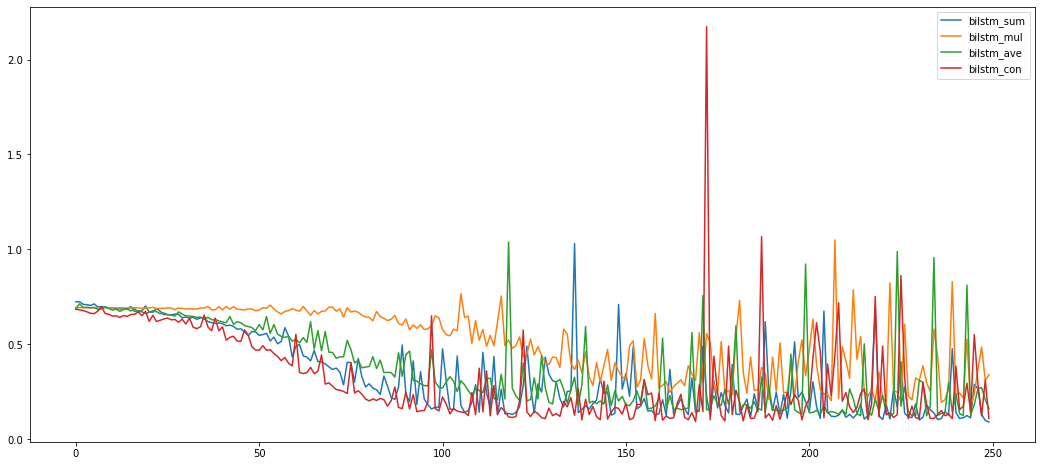

In [12]:
# line plot of results
results.plot(figsize=(18,8))
pyplot.show()